<a href="https://colab.research.google.com/github/yifahadmoni/roarm_m1/blob/main/calibration_and_undisorted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

קוד לקישור הקבצים מהדרייב.

images_for_calibration:
תיקיה עם תמונות שלקחנו של לוח שחמט, איתן נבצע את התהליך של הקליברציה

extract_path:
נתיב שבו נשמרת מחולצות התמונות לקליברציה

file_path:
נתיב לתוצאה של הקליברציה

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# path to the images
images_for_calibration = '/content/drive/My Drive/chessboard_images_detected.zip'

import zipfile
extract_path = "/content/chessboard_images_detected"

with zipfile.ZipFile(images_for_calibration, 'r') as zip_ref:
     zip_ref.extractall(extract_path)

# # Accessing the file
#שם הקובץ עם פרמטרים לכיול
file_path = '/content/drive/My Drive/camera_calibration_output.npz'

# import zipfile
# extract_path_npz = "/content/calibration.npz"

# with zipfile.ZipFile(file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path_npz)

Mounted at /content/drive


code for calibration - results save at "camera_calibration_from_a4" ("content/camera_calibration_from_a4" ?)


In [ ]:
import cv2
import numpy as np
import glob
import os

# ========== הגדרות ==========
checkerboard_dims = (9, 6) # 10 X 7 board
a4_width_mm = 210
a4_height_mm = 297

# גודל ריבוע לפי הדפסה על דף A4
square_size_x = a4_width_mm / 10
square_size_y = a4_height_mm / 7

# יצירת נקודות אובייקט בעולם האמיתי (במ״מ)
objp = np.zeros((checkerboard_dims[0] * checkerboard_dims[1], 3), np.float32)
for j in range(checkerboard_dims[1]):
    for i in range(checkerboard_dims[0]):
        objp[j * checkerboard_dims[0] + i, 0] = i * square_size_x
        objp[j * checkerboard_dims[0] + i, 1] = j * square_size_y

# ========== קריאת התמונות ==========
image_folder = "content/chessboard_images_detected"
image_files = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))

objpoints = []  # נקודות בעולם
imgpoints = []  # נקודות בתמונה
image_size = None

for fname in image_files:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_size = gray.shape[::-1]

    ret, corners = cv2.findChessboardCornersSB(gray, checkerboard_dims, None)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        print(f"[✓] Corners found in {os.path.basename(fname)}")
    else:
        print(f"[✗] Chessboard not found in {os.path.basename(fname)}")

# ========== קליברציה ==========
if objpoints:
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, image_size, None, None
    )

    # שמירה
    np.savez("camera_calibration_from_a4.npz",
             camera_matrix=camera_matrix,
             dist_coeffs=dist_coeffs,
             rvecs=rvecs,
             tvecs=tvecs)

    print("\n✅ Calibration completed.")
    print("Camera Matrix:\n", camera_matrix)
    print("Distortion Coefficients:\n", dist_coeffs)
else:
    print("❌ No valid images. Calibration aborted.")


❌ No valid images. Calibration aborted.


code for correction of new image ("image_path" is the path of the image to correct)


original image



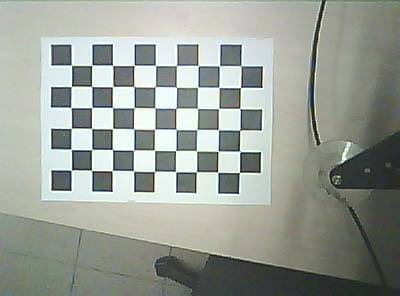

undistorted image


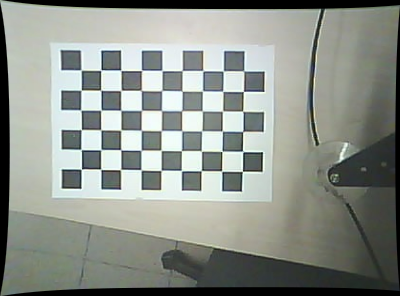

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# ====== טען את הקובץ עם הכיול ======
data = np.load(file_path)
camera_matrix = data["camera_matrix"]
dist_coeffs = data["dist_coeffs"]

# טעינת התמונה שרוצים לתקן - כאן "images.jpg"
image_path = "/content/drive/My Drive/image.jpg"

img = cv2.imread(image_path)
h, w = img.shape[:2]

# תיקון עיוותים לפי הפרמטרים שיצאו מהקליברציה
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
undistorted_img = cv2.undistort(img, camera_matrix, dist_coeffs, None, new_camera_matrix)


cv2.imwrite("undistorted_output.jpg", undistorted_img)
print("original image:\n")
cv2_imshow(img)
print("undistorted image:")
cv2_imshow(undistorted_img)


